In [7]:
import sys
import os
import time
num_devices = 8
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={num_devices}"
sys.path.append('../')
from bo_utils import input_unstandardize
from fb_gp import sample_GP_NUTS
from bo_be import sampler
from ext_loglike import external_loglike
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from jax import config, vmap, jit
config.update("jax_enable_x64", True)
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
from jaxns import NestedSampler, TerminationCondition, resample
import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
from getdist import plots,MCSamples,loadMCSamples
import matplotlib
matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{lmodern}')


In [48]:
def logp(x): # input should be (n x d) and output should be (n x 1) or n
    res = (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
    return -res

ndim = 2
param_bounds= np.array(ndim*[[-2.,2.]]).T

# add result from nested sampler on actual

def prior_transform(x):
    x1,x2 = x
    x1 = -2. + x1*4.
    x2 = -2 + x2*4
    return x1,x2

from dynesty import DynamicNestedSampler

dns = DynamicNestedSampler(logp,prior_transform=prior_transform,ndim=2)
dns.run_nested(print_progress=True,dlogz_init=0.01)
res = dns.results  # grab our results

logz_true = res['logz'][-1]

13371it [00:05, 2426.69it/s, batch: 8 | bound: 5 | nc: 1 | ncall: 114977 | eff(%): 10.948 | loglstar: -5.394 < -0.001 < -0.309 | logz: -4.179 +/-  0.048 | stop:  0.948]          


In [49]:
def jax_ns():    
    def prior_model():
        x = yield Prior(tfpd.Uniform(low=-2*jnp.ones(ndim), high= 2*jnp.ones(ndim)), name='x') # type: ignore
        return x
    
    model_mean = Model(prior_model=prior_model,
              log_likelihood=logp)
    
    term_cond = TerminationCondition(evidence_uncert=1e-2)
    
    start = time.time()
    ns_mean = NestedSampler(model=model_mean,
                        max_samples=1e6,
                        parameter_estimation=True,
                        difficult_model=True)
                        #num_parallel_workers=10)
     # Run the sampler
    termination_reason, state = ns_mean(jax.random.PRNGKey(42),term_cond=term_cond)
    # Get the results
    results = ns_mean.to_results(termination_reason=termination_reason, state=state)

    # ns_mean.plot_cornerplot(results)
    
    mean = results.log_Z_mean
    logz_err = results.log_Z_uncert

    samples = resample(key=jax.random.PRNGKey(0),
                    samples=results.samples,
                    log_weights=results.log_dp_mean, # type: ignore
                    replace=True,) 
    
    return samples, mean, logz_err

samples, mean, logzerr = jax_ns()

print(mean,logzerr)

Running over 8 devices.
-4.2050171034627235 0.19126720008642062


In [50]:
print(samples['x'].shape)

(1573, 2)


In [51]:
# scipy double quad 

from scipy import integrate

logprior = np.log(np.prod(param_bounds[1]-param_bounds[0]))

f = lambda x,y: np.exp(logp([x,y]))

result = integrate.dblquad(f, -2,2, -2,2)

logz = np.log(result[0])

print(logz)
print(logz - logprior)

-1.4857487969680352
-4.258337519207816


In [52]:
gp_samples = np.load('Rosenbrock_samples.npz')

x = [gp_samples[key] for key in gp_samples.keys()]

x = np.array(x)




In [53]:
names = ['x1','x2']

true_samples_jns = MCSamples(samples=samples['x'][::2],names=names) # jaxns
true_samples_dns = MCSamples(samples=res.samples_equal()[::2],names=names) # jaxns



gp_samples = MCSamples(samples=x[::2],names=names)

bf  = [1,1]

markers_bf = dict(zip(names,bf))


Removed no burn in
Removed no burn in
Removed no burn in


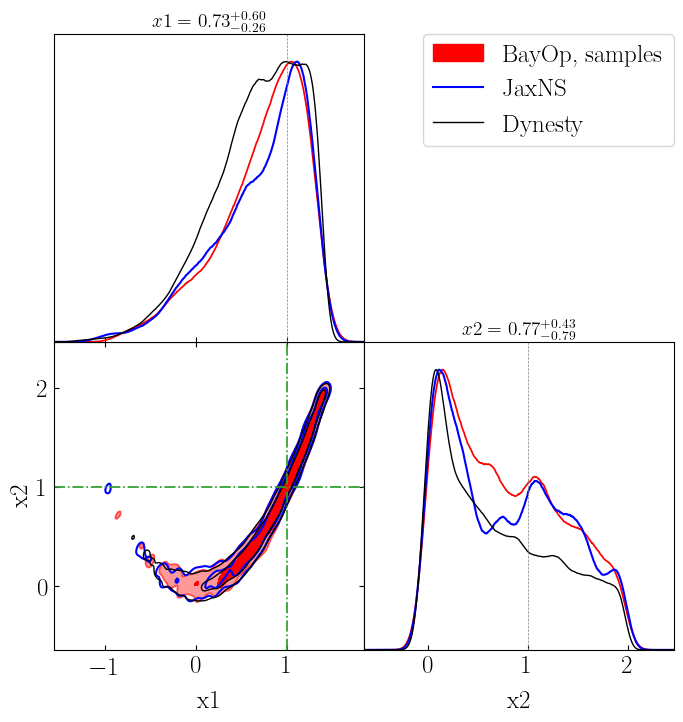

In [54]:
g = plots.get_subplot_plotter(width_inch=8)
g.settings.axes_fontsize=18
g.settings.axes_labelsize = 18
g.settings.legend_fontsize = 18
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples_jns,true_samples_dns], names,filled=[True,False,False],contour_lws=[1.25,1.5,1.],
                  contour_colors=['red','blue','black'],title_limit=1
                  ,markers = markers_bf
                  ,marker_args={'lw': 1.25, 'ls': '-.', 'color': 'C2'}
                  ,legend_labels=[f'BayOp, samples','JaxNS','Dynesty']) 

# for i in range(ndim):
#     ax = g.subplots[i,i]
#     ax.axvline(bf[i], color='C2', ls='-.',lw=1.25)
#     for j in range(i+1,ndim):
#         ax = g.subplots[j,i]
#         ax.scatter(train_x[:,i],train_x[:,j],alpha=0.33,color='c',s=8)
# g.export('Rosenbrock_BO_points.pdf')